# Deep Face Recognition

## 1. Setup

### 1.1 Install Dependencies

In [ ]:
%pip install kagglehub[pandas-datasets]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1.2 Import Dependencies

In [87]:
# Import standard dependencies
import os
import uuid
import cv2
import random
import numpy as np
import shutil
import kagglehub
import pandas as pd
from PIL import Image
from tqdm import tqdm
from typing import Tuple, Dict, List
from matplotlib import pyplot as plt

In [6]:
# Import torch dependencies
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchinfo import summary
from torchmetrics.classification import BinaryConfusionMatrix, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryAccuracy
from torchvision.transforms import transforms
from torch import nn

### 1.3 Device Agnostic Code

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1.4 Setup Folder Structure

In [8]:
# Setup Paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [9]:
# Make directories
if not os.path.exists(POS_PATH):
    os.makedirs(POS_PATH)
if not os.path.exists(NEG_PATH):
    os.makedirs(NEG_PATH)
if not os.path.exists(ANC_PATH):
    os.makedirs(ANC_PATH)

## 2. Collect Positives and Anchors

### 2.1 Untar Labelled Faces in the Wild Dataset

In [10]:
# Download the dataset to the specified path
dataset_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

In [11]:
print(dataset_path)
dataset_path = os.path.join(dataset_path, 'lfw-deepfunneled', 'lfw-deepfunneled')
print(dataset_path)

C:\Users\LOQ\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4
C:\Users\LOQ\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled\lfw-deepfunneled


In [12]:
# Move LFW to negative floder
print(f"Moved images to {NEG_PATH}...")

for directory in os.listdir(dataset_path):
    person_folder = os.path.join(dataset_path, directory)
    for file in os.listdir(person_folder):
        EX_PATH = os.path.join(person_folder, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        shutil.move(EX_PATH, NEW_PATH)

print("DONE✅")

Moved images to data\negative...
DONE✅


### 2.2 Collecting Positives and Anchors
> Running this cell will open your camera!

In [113]:
# Establish a Connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250x250 pixels    
    x, y = 30, 300
    frame = frame[x:x+250,y:y+250,:]

    # Collect Anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create a unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Save the Anchor image
        cv2.imwrite(imgname, frame)

    # Collect Positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create a unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Save the Positive image
        cv2.imwrite(imgname, frame)


    # Show image back to screen
    cv2.imshow('Image Collection', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [114]:
frame.shape

(250, 250, 3)

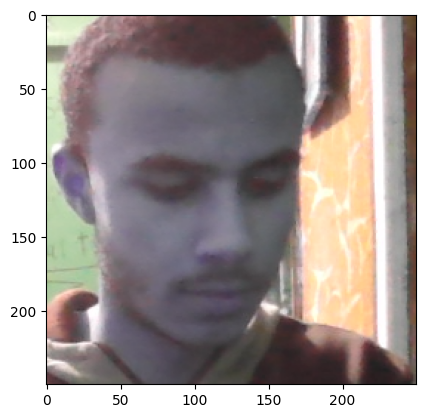

In [133]:
plt.imshow(frame)
plt.show()

## 3. Load and Process Images

### 3.1 Create transform function

In [20]:
transform = transforms.Compose([
    transforms.Resize((105, 105)),
    transforms.ToTensor()
])

### 3.2 Create Dataset class

In [43]:
class DFR_Dataset(Dataset):
    def __init__(self,
                 anc_path,
                 pos_path,
                 neg_path,
                 num_samples=300,
                 transform=transform):
        
        self.transform = transform
        self.length = num_samples * 2

        # List .jpg files from each directory and take num_samples
        self.anc_files = [os.path.join(anc_path, f) for f in os.listdir(anc_path) 
                            if f.endswith('.jpg')][:num_samples]
        self.pos_files = [os.path.join(pos_path, f) for f in os.listdir(pos_path) 
                          if f.endswith('.jpg')][:num_samples]
        self.neg_files = [os.path.join(neg_path, f) for f in os.listdir(neg_path) 
                          if f.endswith('.jpg')][:num_samples]

        self.positives = list(zip(self.anc_files, self.pos_files, np.ones(num_samples)))
        self.negatives = list(zip(self.anc_files, self.neg_files, np.zeros(num_samples)))

        self.data = self.positives + self.negatives

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
            # Load images
            anchor_img = Image.open(self.data[idx][0]).convert('RGB')
            other_img = Image.open(self.data[idx][1]).convert('RGB')
            label = self.data[idx][2]

            # Apply transformations if specified
            if self.transform:
                anchor_img = self.transform(anchor_img)
                other_img = self.transform(other_img)

            return anchor_img, other_img, label

In [44]:
dataset = DFR_Dataset(
    anc_path=ANC_PATH,
    pos_path=POS_PATH,
    neg_path=NEG_PATH,
    num_samples=300,
    transform=transform
)

data_size = len(dataset)
print(data_size)
train_size = int(data_size * 0.7)
test_size = data_size - train_size

train_dataset, test_dataset = random_split(dataset=dataset, lengths=[train_size, test_size])
print(f"Train Size: {len(train_dataset)}, Test Size: {len(test_dataset)}")

600
Train Size: 420, Test Size: 180


### 3.3 Create DataLoader

In [45]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

In [46]:
next(iter(train_dataloader))[1]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0000],
          [0.0078, 0.0039, 0.0078,  ..., 0.0039, 0.0039, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0

## 4. Model Engineering

### 4.1 Embedding Model

In [47]:
class EmbeddingModel(nn.Module):
    def __init__(self, in_shape, out_shape):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=in_shape, out_channels=64, kernel_size=10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4),
            nn.ReLU(),
        )

        self.linear_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=9216, out_features=out_shape),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.linear_block(x)
        return x

In [48]:
embedding_model = EmbeddingModel(in_shape=3, out_shape=4096)
summary(model=embedding_model, input_size=(1, 3, 105, 105))

Layer (type:depth-idx)                   Output Shape              Param #
EmbeddingModel                           [1, 4096]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 96, 96]           19,264
│    └─ReLU: 2-2                         [1, 64, 96, 96]           --
│    └─MaxPool2d: 2-3                    [1, 64, 48, 48]           --
│    └─Conv2d: 2-4                       [1, 128, 42, 42]          401,536
│    └─ReLU: 2-5                         [1, 128, 42, 42]          --
│    └─MaxPool2d: 2-6                    [1, 128, 21, 21]          --
│    └─Conv2d: 2-7                       [1, 128, 18, 18]          262,272
│    └─ReLU: 2-8                         [1, 128, 18, 18]          --
│    └─MaxPool2d: 2-9                    [1, 128, 9, 9]            --
│    └─Conv2d: 2-10                      [1, 256, 6, 6]            524,544
│    └─ReLU: 2-11                        [1, 256, 6, 6]           

### 4.2 Build Distance Layer

In [49]:
class L1Dist(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, in_embedding, val_embedding):
        return torch.abs(in_embedding - val_embedding)

In [50]:
l1 = L1Dist()

### 4.3 Build Siamese Network

In [51]:
class SiameseNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = EmbeddingModel(in_shape=3, out_shape=4096)
        self.l1_dist = L1Dist()
        self.classifier = nn.Linear(4096, 1)

    def forward(self, x_anc, x_val):
        anc_embedding = self.embedding(x_anc)
        val_embedding = self.embedding(x_val)
        l1_distance = self.l1_dist(anc_embedding, val_embedding)
        return self.classifier(l1_distance)

In [52]:
Siamese_Model = SiameseNN()
summary(
    Siamese_Model,
    input_data=((torch.randn(1, 3, 105, 105), torch.randn(1, 3, 105, 105))),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    depth=4
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
SiameseNN                                [1, 3, 105, 105]          [1, 1]                    --                        --
├─EmbeddingModel: 1-1                    [1, 3, 105, 105]          [1, 4096]                 --                        --
│    └─Sequential: 2-1                   [1, 3, 105, 105]          [1, 256, 6, 6]            --                        --
│    │    └─Conv2d: 3-1                  [1, 3, 105, 105]          [1, 64, 96, 96]           19,264                    [10, 10]
│    │    └─ReLU: 3-2                    [1, 64, 96, 96]           [1, 64, 96, 96]           --                        --
│    │    └─MaxPool2d: 3-3               [1, 64, 96, 96]           [1, 64, 48, 48]           --                        2
│    │    └─Conv2d: 3-4                  [1, 64, 48, 48]           [1, 128, 42, 42]          401,536                   [7, 7]
│    

## 5. Training

### 5.0 Sanity Check

In [53]:
in_sampe, val_sample, label = dataset[0]
sc_out = Siamese_Model(in_sampe.unsqueeze(0), val_sample.unsqueeze(0))
sc_out

tensor([[-0.0022]], grad_fn=<AddmmBackward0>)

### 5.1 Setup Loss and Optimizer

In [54]:
# Loss function
loss_fn = nn.BCEWithLogitsLoss()

# Accuracy Function
acc_fn = BinaryAccuracy()

# Precision
prec_fn = BinaryPrecision()
# Recall
recall_fn = BinaryRecall()
# f1-score
f1_score = BinaryF1Score()

# Optimizer
optimizer = torch.optim.AdamW(params=Siamese_Model.parameters(), lr=0.0001)

### 5.2 Establish Checkpoints

In [55]:
checkpoint_dir = r'E:\Data Science\projects\Deep-Facial-Recognition\pytorch\training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

# 6. Save model checkpoint dynamically
# checkpoint = {
#     'epoch': epoch + 1,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'train_loss': train_loss,
#     'test_loss': test_loss,
#     'train_accuracy': train_acc,
#     'test_accuracy': test_acc
# }

### 5.3 Build Training & Testing Step

In [56]:
# Training step function
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               acc_fn,
               device: torch.device = device):
    # Put the model and acc function on the target device
    model.to(device)
    acc_fn.to(device)

    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader
    for batch, (anchor_img, val_img, labels) in enumerate(data_loader):
        # Send data to target device
        anchor_img, val_img, labels = anchor_img.to(device), val_img.to(device), labels.to(device)
        
        # 1. Forward pass
        y_logits = model(anchor_img, val_img).squeeze(dim=1)

        # Convert logits -> pred probs
        y_pred_probs = torch.sigmoid(y_logits)

        # Convert pred probs -> pred labels
        y_pred_labels = torch.round(y_pred_probs)

        # 2. Calculate the loss
        loss = loss_fn(y_logits, labels)
        train_loss += loss.item()

        # Calculate the accuracy metric
        acc = acc_fn(y_pred_labels, labels)
        train_acc += acc.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
    
    # Adjust metrics to get average loss and accuracy per batch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

In [57]:
# Testing step function
def test_step(model: nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              acc_fn,
              precision_fn = BinaryPrecision(),
              recall_fn = BinaryRecall(),
              f1_score_fn = BinaryF1Score(),
              device: torch.device = device):
    """Testing step using model on the data loader.
    
    Returns:
        test_loss (float): Loss on data loader
        test_acc (float): Accuracy of the model on data loader
        test_precision (float): precision metric value on data loader
        test_recall (float): recall metric value
        test_f1_score (float): f1-score metric value on data loader
    """
    # Send model and evaluation metrics to target device
    model.to(device)
    acc_fn.to(device)
    precision_fn.to(device)
    recall_fn.to(device)
    f1_score_fn.to(device)

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Setup Evaluation metrics
    test_precision, test_recall, test_f1_score = 0, 0, 0

    # Put model in evaluation mode
    model.eval()
    with torch.inference_mode():
        for batch, (anchor_img, val_img, labels) in enumerate(data_loader):
            # Send data to target device
            anchor_img, val_img, labels = anchor_img.to(device), val_img.to(device), labels.to(device)
            
            # 1. Forward pass
            test_pred_logits = model(anchor_img, val_img).squeeze(dim=1)

            # Convert logits -> prediction labels
            test_pred_labels = torch.round(torch.sigmoid(test_pred_logits))

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, labels)
            test_loss += loss.item()

            # Calculate the accuracy
            test_acc += acc_fn(test_pred_labels, labels).item()

            # Calculate evaluation metrics (precision, recall, f1-score)
            precision = precision_fn(test_pred_labels, labels)
            test_precision += precision.item()
            recall = recall_fn(test_pred_labels, labels)
            test_recall += recall.item()
            f1_score = f1_score_fn(test_pred_labels, labels)
            test_f1_score += f1_score.item()
        
        # Adjust the metrics to get the average loss and accuracy per batch
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        test_precision /= len(data_loader)
        test_recall /= len(data_loader)
        test_f1_score /= len(data_loader)
    return test_loss, test_acc, test_precision, test_recall, test_f1_score

### 5.4 Build Training Loop

In [58]:
# Training loop function

# 1. Create a train function that takes in various model parameters
def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          acc_fn,
          optimizer: torch.optim.Optimizer,
          epochs: int = 5,
          device: torch.device = device,
          save_path: str = checkpoint_prefix):
    # 2. Create an empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": [],
               "test_precision": [],
               "test_recall": [],
               "test_f1_score": []}
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           acc_fn=acc_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc, test_precision, test_recall, test_f1_score = test_step(
            model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            device=device
        )
        
        # 4. Print out what's happening
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {100*train_acc:.2f}%")

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_precision"].append(test_precision)
        results["test_recall"].append(test_recall)
        results["test_f1_score"].append(test_f1_score)

        # 6. Save model checkpoint dynamically
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc
        }

        if epoch % 2 == 0:
            torch.save(checkpoint, f"{save_path}_epoch_{epoch + 1}.pth")
            print(f"Checkpoint saved for epoch {epoch + 1}\n")

    # 7. Return the filled results at the end of the epochs
    return results

### 5.5 Train the Model

In [59]:
EPOCHS = 10
results_dict = train(
    model=Siamese_Model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    acc_fn=acc_fn,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    save_path=checkpoint_prefix
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.4034 | Train acc: 87.50%


 10%|█         | 1/10 [00:04<00:44,  4.98s/it]

Checkpoint saved for epoch 1



 20%|██        | 2/10 [00:08<00:33,  4.14s/it]

Epoch: 1 | Train loss: 0.0860 | Train acc: 99.31%
Epoch: 2 | Train loss: 0.0692 | Train acc: 98.61%


 30%|███       | 3/10 [00:12<00:29,  4.29s/it]

Checkpoint saved for epoch 3



 40%|████      | 4/10 [00:17<00:25,  4.22s/it]

Epoch: 3 | Train loss: 0.0404 | Train acc: 99.77%
Epoch: 4 | Train loss: 0.0177 | Train acc: 99.77%


 50%|█████     | 5/10 [00:22<00:22,  4.48s/it]

Checkpoint saved for epoch 5



 60%|██████    | 6/10 [00:26<00:17,  4.36s/it]

Epoch: 5 | Train loss: 0.0065 | Train acc: 100.00%
Epoch: 6 | Train loss: 0.0043 | Train acc: 100.00%


 70%|███████   | 7/10 [00:31<00:13,  4.54s/it]

Checkpoint saved for epoch 7



 80%|████████  | 8/10 [00:35<00:08,  4.45s/it]

Epoch: 7 | Train loss: 0.0032 | Train acc: 100.00%
Epoch: 8 | Train loss: 0.1119 | Train acc: 97.22%


 90%|█████████ | 9/10 [00:40<00:04,  4.57s/it]

Checkpoint saved for epoch 9



100%|██████████| 10/10 [00:43<00:00,  4.38s/it]

Epoch: 9 | Train loss: 0.1439 | Train acc: 98.38%


## 6. Evaluate the Model

### 6.1 Sample Random Images

In [82]:
import random
# random.seed = 42
test_samples = []
test_labels = []
for in_sample, val_sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append((in_sample, val_sample))
    test_labels.append(label)

# View the first sample shape
test_samples[0][0].shape

torch.Size([3, 105, 105])

### 6.2 Make Predictions

In [83]:
def make_predictions(model: nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            in_sample = torch.unsqueeze(sample[0], dim=0).to(device)
            val_sample = torch.unsqueeze(sample[1], dim=0).to(device)

            # Forward pass (model outputs)
            pred_logits = model(in_sample, val_sample)

            # GGet prediction probabilities (logits -> probabilities)
            pred_prob = torch.sigmoid(pred_logits.squeeze())

            # Get pred_prob off the GPU
            pred_probs.append(pred_prob.cpu())
    
    # Stack the pre_probs to turn  list into a tensor
    return torch.stack(pred_probs)

In [84]:
# Make predictions
pred_probs = make_predictions(model=Siamese_Model,
                              data=test_samples,
                              device=device)

# View the first two prediction probabilities
pred_probs[:2]

tensor([2.2471e-05, 2.1872e-05])

In [85]:
# Convert prediction probabilities to labels
pred_classes = torch.round(pred_probs).type(torch.int)
pred_classes

tensor([0, 0, 1, 0, 1, 0, 0, 1, 1], dtype=torch.int32)

### 6.3 Plot Predictions

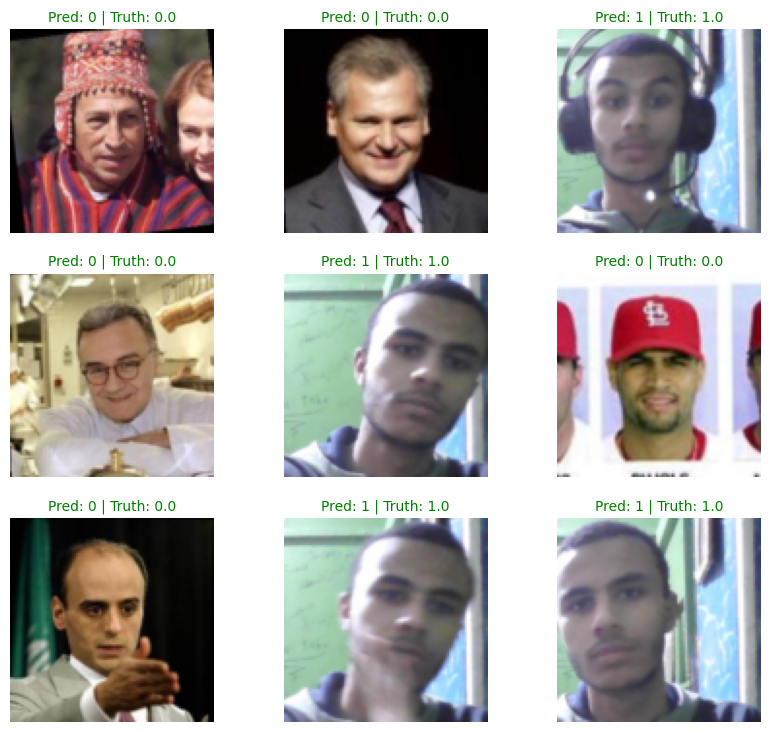

In [86]:
# Plot predictions
plt.figure(figsize=(10, 9))
nrows, ncols = 3, 3
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the image
    plt.imshow(sample[1].permute(1, 2, 0))

    # Find the prediction label
    pred_label = pred_classes[i]

    # Find the truth label
    truth_label = test_labels[i]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')

    plt.axis(False)

### 6.4 Plot Some Curves

In [88]:
# Plot loss curves
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary."""
    # Get the loss values of the results dictionary (training and test)
    loss = results["train_loss"] 
    test_loss = results["test_loss"]

    # Get the accuracy values of the results of dictionary (training and test)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(EPOCHS)

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_acc")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

In [97]:
# 1. Make predictions with trained model
y_preds = []
y_targets = []
Siamese_Model.eval()
with torch.inference_mode():
    for in_X, val_X, y in tqdm(test_dataloader, desc="Making predictions..."):
        # Send the data to target device
        in_X, val_X, y = in_X.to(device), val_X.to(device), y.to(device)
        y_targets.extend(y)
        # Do forward pas
        y_logits = Siamese_Model(in_X, val_X).squeeze(dim=1)
        # Turn from logits -> probs -> labels
        y_pred = torch.sigmoid(y_logits)
        # Put predictions on CPU
        y_preds.append(y_pred.cpu())

# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

Making predictions...: 100%|██████████| 12/12 [00:01<00:00, 11.60it/s]


tensor([5.6329e-04, 8.4658e-01, 5.3314e-04, 8.9099e-01, 9.4825e-01, 2.5676e-05,
        8.2583e-01, 2.7373e-04, 9.4209e-04, 4.8430e-05])

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = BinaryConfusionMatrix()
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.Tensor(y_targets))

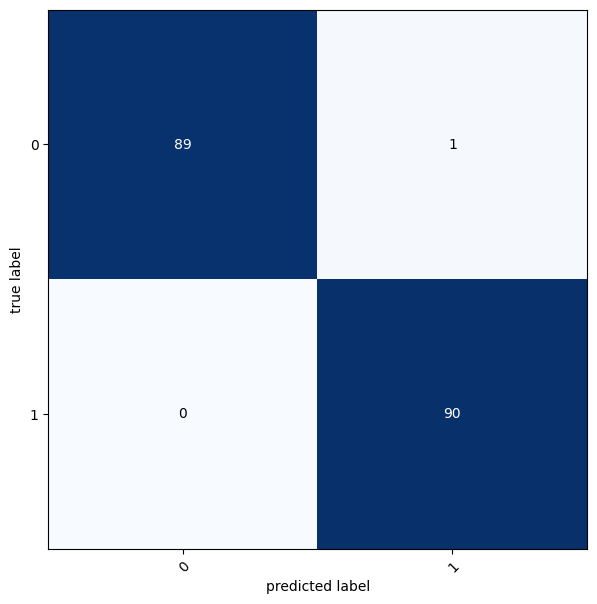

In [102]:
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib works with numpy
    class_names=[0, 1],
    figsize=(10, 7)
)

In [104]:
# Plotting Evaluation metrics through epochs
def plot_evaluation_metrics(results_dict, title="Evaluation Metrics Over Epochs"):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 7))
    # Plot accuracy through epochs
    metric = BinaryAccuracy()
    values = torch.Tensor(results_dict["test_acc"])
    fig_, ax_ = metric.plot(values, ax1)
    
    # Plot precision through epochs
    metric = BinaryPrecision()
    values = torch.Tensor(results_dict["test_precision"])
    fig_, ax_ = metric.plot(values, ax2)

    # Plot recall through epochs
    metric = BinaryRecall()
    values = torch.Tensor(results_dict["test_recall"])
    fig_, ax_ = metric.plot(values, ax3)

    # Plot recall through epochs
    metric = BinaryF1Score()
    values = torch.Tensor(results_dict["test_f1_score"])
    fig_, ax_ = metric.plot(values, ax4)

    # Add a title to the entire figure
    fig.suptitle(title, fontsize=20)

    # Adjust spacing to fit the title and plots
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
    
    plt.show()

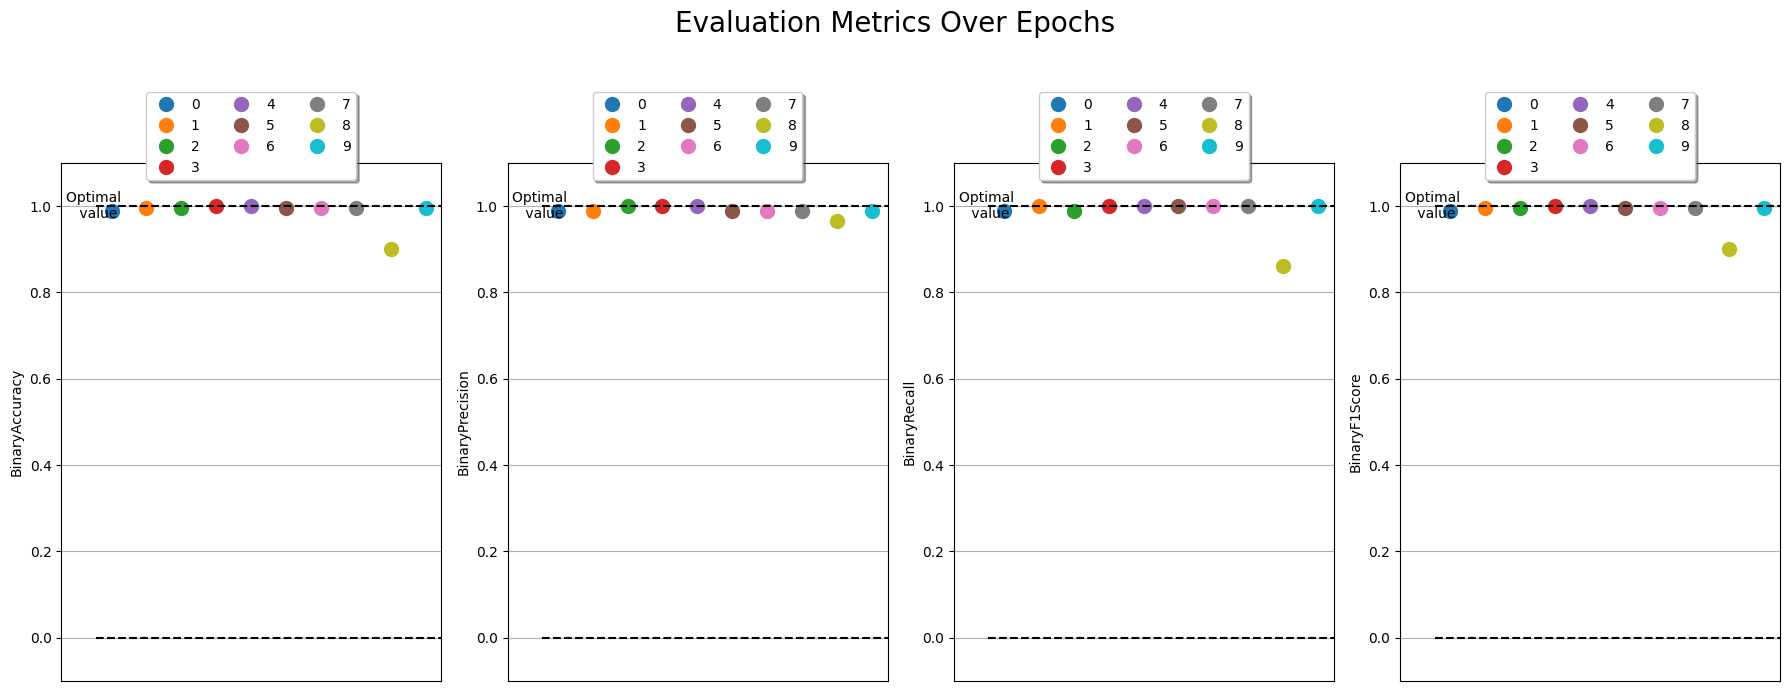

In [106]:
plot_evaluation_metrics(results_dict)

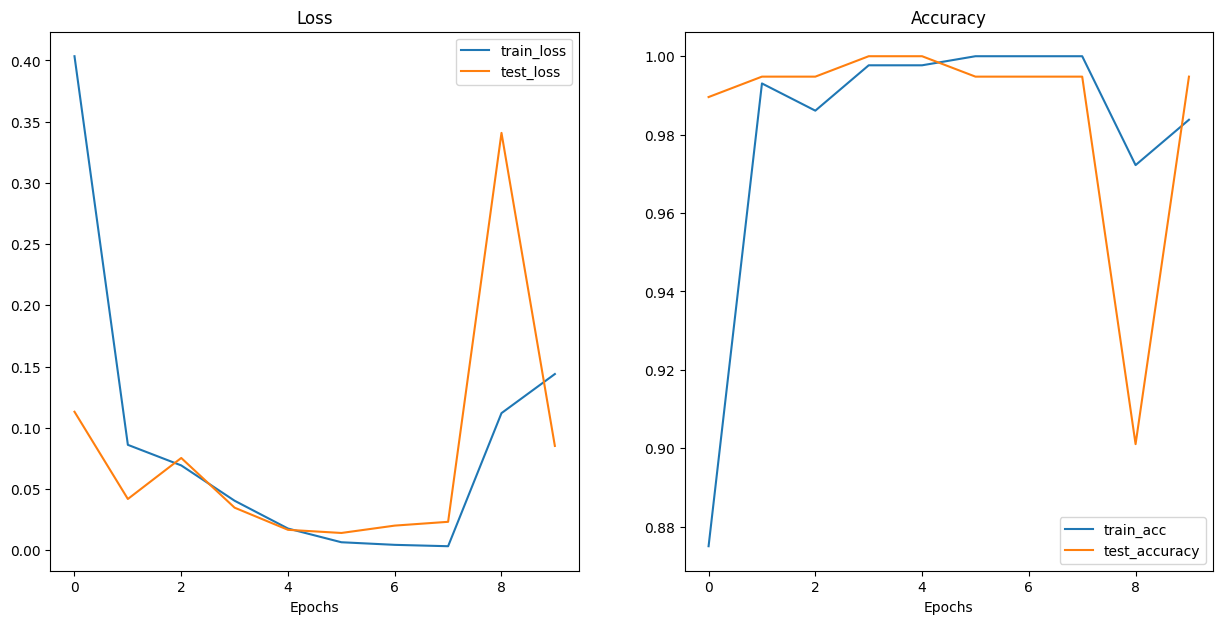

In [103]:
plot_loss_curves(results_dict)

## 7. Save the Model

In [107]:
from pathlib import Path

# Create a model directory path
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "siamese_network.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

WindowsPath('models/siamese_network.pth')

In [108]:
# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=Siamese_Model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models\siamese_network.pth


In [109]:
# Create a new instance
torch.manual_seed = 42
Siamese_Model_Loaded = SiameseNN()

# Load in the saved state_dict()
Siamese_Model_Loaded.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to the target device
Siamese_Model_Loaded.to(device)

C:\Users\LOQ\AppData\Local\Temp\ipykernel_16360\420759793.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Siamese_Model_Loaded.load_state_dict(torch.load(f=MODEL_SAVE_PA

SiameseNN(
  (embedding): EmbeddingModel(
    (conv_block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
      (10): ReLU()
    )
    (linear_block): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=9216, out_features=4096, bias=True)
      (2): Sigmoid()
    )
  )
  (l1_dist): L1Dist()
  (classifier): Linear(in_features=4096, out_features=1, bias=True)
)

## 8. Real Time Test \[WIP]